<a href="https://colab.research.google.com/github/shubham953/Donut_LLM_Gen-AI/blob/main/Donut_working_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Donut
Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding.

it uses Swin transformer(a computer vision tf) as encoder to transform an image inti the embaddings used to input in decoder with some addition inputs and BART as decoder which can be seen as combination of bert+gpt3

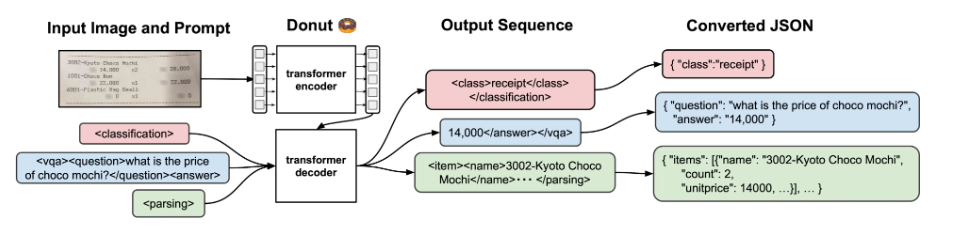

We will use the **SROIE** dataset a collection of scanned receipts image(in data/img), including their OCR(data/key). More information for the dataset can be found at the repository [link text](https://github.com/zzzDavid/ICDAR-2019-SROIE)

The task of above model to extract the inforemation from a given image of a reciept as a jeson file known as key.

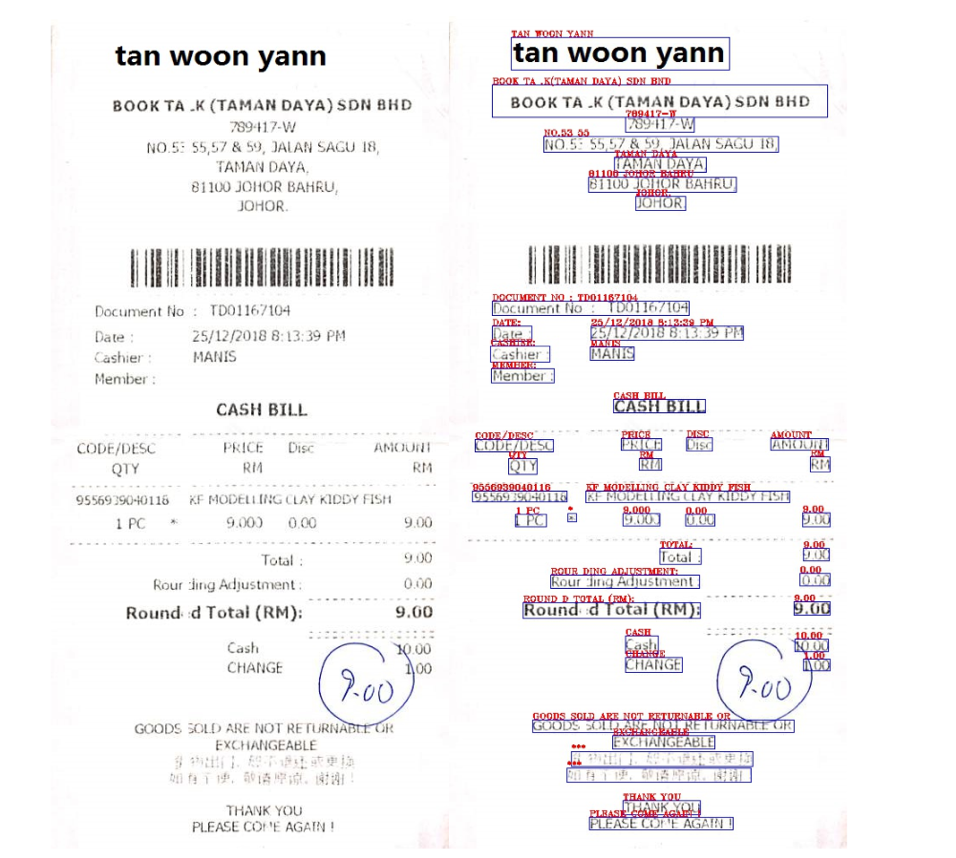

For the information extraction task, each image in the dataset is annotated with a text file with format shown below:

{
  "company": "STARBUCKS STORE #10208",
  "address": "11302 EUCLID AVENUE, CLEVELAND, OH (216) 229-0749",
  "date": "14/03/2015",
  "total": "4.95"
}


##  **Step 1: Download the github repository**

 We will clone the github repository with the SROIE (bills) dataset that will be used to fine tune the pre-trained model and then remove unnecessary files. This is required for loading SROIE data from [link text](https://github.com/zzzDavid/ICDAR-2019-SROIE.git) . We keep separate folder for images and a separate folder for correspomding  OCR.

 Final files contain the our input data set from a model in the prvided link.

In [ ]:
%cd /content
# clone repository
!git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git

# copy data
!cp -r ICDAR-2019-SROIE/data ./
# clean up
!rm -rf ICDAR-2019-SROIE
!rm -rf data/box


/content
Cloning into 'ICDAR-2019-SROIE'...
remote: Enumerating objects: 2386, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2386 (delta 18), reused 18 (delta 18), pack-reused 2366
Receiving objects: 100% (2386/2386), 278.64 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (1980/1980), done.


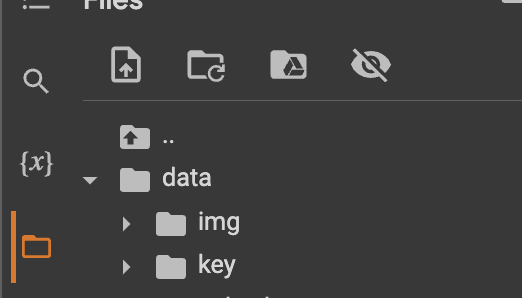

## **Step 2: Download the pre-trained donut model and importing libraries**

To interact with Hugging Face's model hub, which provides access to pre-trained models and other resources for natural language processing tasks we need to install huggingface_hub package.

We are using Hugging face for quick implementation so we need to insatall Transformers(1,2 in following code cell) from it which is-

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.4 MB/s eta 0:00:00


### Install hugging face models, transformers

In [ ]:
# !pip install -q git+https://github.com/huggingface/transformers.git
!pip install transformers
!install git-fls for pushing model and logs to the hugging face hub
!pip install transformers[torch]
!pip install huggingface_hub
!pip install scikit-learn
!pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
install: target 'hub' is not a directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00


### Import relevant packages and modules

In [ ]:
import os
import json
from pathlib import Path
import shutil

#loading dataset
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

import random

from transformers import DonutProcessor

import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

from tqdm import tqdm

import torch

## **Step 3: Data preprocessing**



## 3a. Create `jsonl` file
The SROIE dataset downloaded from the github repo is the earlier step is not comapatible with hugging face, hence we need to make a new `jsonl` file via stacking image and text together `['img','text']`

JSONL file is a text file that contains a sequence of JSON objects, separated by newline characters

{"name": "John Doe", "age": 30}\
{"name": "Jane Doe", "age": 25}

Stack image to its corresponding key in json file then remove the key file

In [ ]:
# define paths
base_path = Path("/content/data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file) #It loads the JSON data from the file using the json.load() function, storing the result in the data variable.
    # create "text" column with json string

    text = json.dumps(data)
                      #It converts the data object back into a JSON-formatted string using json.dumps(), and assigns it to the text variable.
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file

# write jsonl file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)


## 3b. Load the dataset from newly created `jsonl` file

Loading the hugging face compatible jsonl(made in previous cell) file data

In [ ]:
# define paths
base_path = Path("/content/data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split='train')


print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")


Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


To see a random data of our dataset

Random sample is 150
OCR text is {"company": "SWC ENTERPRISE SDN BHD", "date": "28/03/2018", "address": "5-7, JALAN MAHAGONI 7/1 SEKSYEN 4, BANDAR UTAMA, 44300 BATANG KALI, SELANGOR", "total": "30.00"}


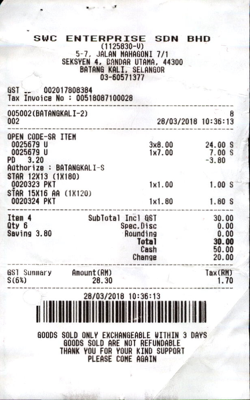

In [ ]:
random_sample = random.randint(0, len(dataset))
print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
# OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


## 3c. Create **Special Tokens** - Comes under the BART model inside of donut transformer


Model converts all the strings into a corresponding integer to work efficiently, so the words that are not in its vocabulory we have to give them separately so at the time of execution processor knows that this word is already present .
We have to add following strings to processor's vocabulory


```
['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']

```


Now for decoder generating the sequence we have added the tokens like


```
<s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
```
This will help decoder to form a correct sequence as all the words are already present defaut+special added ones so it can prduce the desired sequence








In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    This is custome function built by ClovaAI team to Convert an ordered JSON object into a Donut token sequence
    Parameters:
1. obj: The Data that will be passed to this function for Donut Style Tokenisation
2. update_special_tokens_for_json_key: if True, The Special Token will added to the token of the specific class/key
3. sort_json_key: Sorting of the keys will happen to Retructure the Dictionary if required for all the samples
    """
    if type(obj) == dict: # if the Object is a dictionary, That Means It will have keys in which Words/Tokens need to be tokenise in Donut Format
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else: # For non blank Dictionaries
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key: # Updating the Special Token List with new tokens. This way the Special Tokens will be configured for all the Keys
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key) # Recursing to assign the Keys to json2token function to return the Values for that key
                    + fr"</s_{k}>"
                ) # The Output for the each Key will be "<s_{k}> Value </s_{k}>"
            return output
    elif type(obj) == list: # If the Object is List, That implies it is A sequnce whihc should be classified with
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


## 3d. Load processor from pretrained donut model and add special tokens to the processor

```
naver-clova-ix/donut-base
```



In [ ]:
# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:189: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Let's tokenize our input text, Donut uses tokenizer as word piece tokenizer.

This tokenizer will add all those sub words into the library of the tokenizer which are having more scores based on the probablity score as


```
# score=(freq_of_pair)/(freq_of_first_element×freq_of_second_element)
```
To learn more about the tokenization, you can refer:
1. [Word piece tokenizer](https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt)

2. [Bert tokenization](https://albertauyeung.github.io/2020/06/19/bert-tokenization.html/)


In [ ]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze() # This part removes additional Dimensionality and return images as tensors
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document- input_id are the tensors of the word with tokenisation without adding special tokens
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,# Add [CLS] and [SEP]
        max_length=max_length,# maximum length of a sentence
        padding="max_length",
        truncation=True,
        return_tensors="pt", # ask the function to return PyTorch tensors
    )["input_ids"].squeeze(0)

    labels = input_ids.clone() # Lables are the Text Output Tensors padded to the required size
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this

#In this part, We are converting the Product Dataset already prepared with speical tokens, in Tensors with the dimensionality required for the Donut
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])
# Thie Image columns is converted to pixel_values & text to labels

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

## 3e. Spliting the dataset into train and test datasets

Training images: 219
Test images: 94

In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


## **Step 4. Fine-tune model**

## We can see donut as


```
Donut = Swin (a computer vision image reconition transformer ) + BART(a decoder)
```


```
BART = BERT(language representation model) + GPT(Auto Regressive mode)
BERT = generation of missing statement,distorted etc
GPT = used for prediction next statement  
```


```
# so the flow of the model can be seen as
INPUT IMAGE -> Swin Transformer->
                                   BART->Sequence->output
(input sequance)ground truth   ->
```








```
# We have added new tokens to the vocablory in terms of special tokens now we have to resize embedings .
# the example of bert embeding BART have the same embeding
# position one it learns itself
```
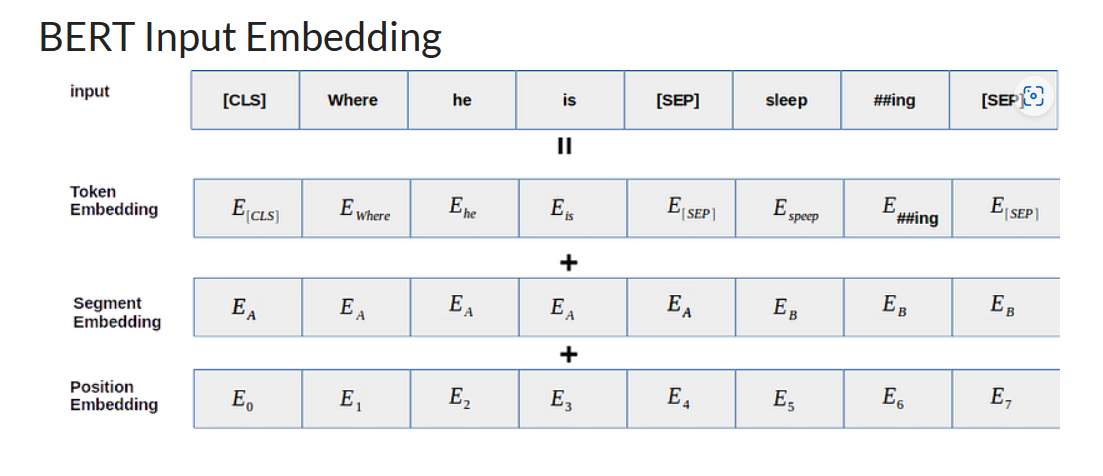




## 4a. Load model and set input parameters

In [ ]:
# Load model from huggingface.com
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")

# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


New embedding size: Embedding(57533, 1024)


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

As model is pretrained it learns its charecterstics in terms of weights in hidden state. So if we use previously learned model to our model, it is easier to learn new one as it already has the previous context knowlege of earlier model. Hence, the model will coverge to new dataset faster. This called as Fine tuning of the model

Now for fine tuning the existing model which is donut, we provide our hyperparameters with the help of hugging face `seq2seq` model.and save it in hugging face repository

checkpoints --> means saved weights of previous model

In [ ]:
# hyperparameters used for multiple args


# Arguments for training
training_args = Seq2SeqTrainingArguments(

    output_dir="donut_soroi",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id="donut_soroie",
    hub_token=HfFolder.get_token()
    # optim='adamw_torch',
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Start training
trainer.train()

Step,Training Loss
100,3.146600
200,1.142400
300,0.646600
400,0.622500
500,0.443500
600,0.390300
700,0.291500
800,0.314800


TrainOutput(global_step=846, training_loss=0.8474392383656604, metrics={'train_runtime': 2095.4503, 'train_samples_per_second': 0.806, 'train_steps_per_second': 0.404, 'total_flos': 2.970761500447949e+18, 'train_loss': 0.8474392383656604, 'epoch': 3.0})

## **Step 5: Save the model and predict**

In [ ]:
# Save processor and create model card
# processor.save_pretrained(hf_repository_id)
processor.save_pretrained("/content/donut_soroi/a")
trainer.create_model_card()
#trainer.push_to_hub()


In [ ]:

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 5)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
# processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Reference:
 {'total': '5.80', 'date': '24/07/2017', 'company': 'SANYU STATIONERY SHOP', 'address': 'NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM'}
Prediction:
 {'total': '5.80', 'date': '24/07/2017', 'company': 'SANYU STATIONERY SHOP', 'address': 'NO. 31G&33G, JALAN SETIA INDAH X,U13/X 40170 SETIA ALAM'}


In [ ]:

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")



100%|██████████| 63/63 [01:33<00:00,  1.48s/it]

Accuracy: 75.0%
